In [1]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [3]:
# parameters
learning_rate = 1e-2
training_epochs = 10
batch_size = 32

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 108697227.50it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 13391078.25it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26975475.17it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7287884.00it/s]


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [5]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [6]:
# nn layers
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

# BatchNorm 을 적용하지 않는 layer
nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

In [7]:
# model with BatchNorm
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                               linear2, bn2, relu,
                               linear3).to(device)
# model without BatchNorm
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [9]:
# define cost / loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [10]:
# 그래프를 그리기위해 매 epoch 마다 손실값과 정확도를 저장할 용도의 빈 리스트 생성
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)

for epoch in range(training_epochs):
  bn_model.train()    # set the training mode

  for X, Y in train_loader:
    X = X.view(-1, 28 * 28).to(device)
    Y = Y.to(device)

    bn_optimizer.zero_grad()
    bn_prediction = bn_model(X)
    bn_loss = criterion(bn_prediction, Y)
    bn_loss.backward()
    bn_optimizer.step()

    nn_optimizer.zero_grad()
    nn_prediction = nn_model(X)
    nn_loss = criterion(nn_prediction, Y)
    nn_loss.backward()
    nn_optimizer.step()

  with torch.no_grad():
    bn_model.eval()    # set the evaluation mode

    bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
    for i, (X, Y) in enumerate(train_loader):
      X = X.view(-1, 28 * 28).to(device)
      Y = Y.to(device)

      bn_prediction = bn_model(X)
      bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
      bn_loss += criterion(bn_prediction, Y)
      bn_acc += bn_correct_prediction.float().mean()

      nn_prediction = nn_model(X)
      nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
      nn_loss += criterion(nn_prediction, Y)
      nn_acc += nn_correct_prediction.float().mean()

    bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

    # Save valid losses/acc
    valid_losses.append([bn_loss, nn_loss])
    valid_accs.append([bn_acc, nn_acc])
    print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc):%.5f(%.2f) vs No Batchnorm Loss(Acc):%.5f(%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
    print()

print('Learning finished')

[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.80639(bn_acc:5.76) vs No Batchnorm Loss(Acc): nn_loss:1.08817(nn_acc:5.67)

[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.60365(bn_acc:5.82) vs No Batchnorm Loss(Acc): nn_loss:1.18253(nn_acc:5.69)

[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.50848(bn_acc:5.85) vs No Batchnorm Loss(Acc): nn_loss:0.82901(nn_acc:5.76)

[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.44645(bn_acc:5.87) vs No Batchnorm Loss(Acc): nn_loss:0.85256(nn_acc:5.77)

[Epoch 5-VALID] Batchnorm Loss(Acc): bn_loss:0.42186(bn_acc:5.88) vs No Batchnorm Loss(Acc): nn_loss:0.69567(nn_acc:5.81)

[Epoch 6-VALID] Batchnorm Loss(Acc): bn_loss:0.38403(bn_acc:5.89) vs No Batchnorm Loss(Acc): nn_loss:0.81108(nn_acc:5.78)

[Epoch 7-VALID] Batchnorm Loss(Acc): bn_loss:0.33293(bn_acc:5.91) vs No Batchnorm Loss(Acc): nn_loss:0.75121(nn_acc:5.79)

[Epoch 8-VALID] Batchnorm Loss(Acc): bn_loss:0.32418(bn_acc:5.90) vs No Batchnorm Loss(Acc): nn_loss:0.69813(nn_acc:5.80)

[Epoch 9-VALID] 

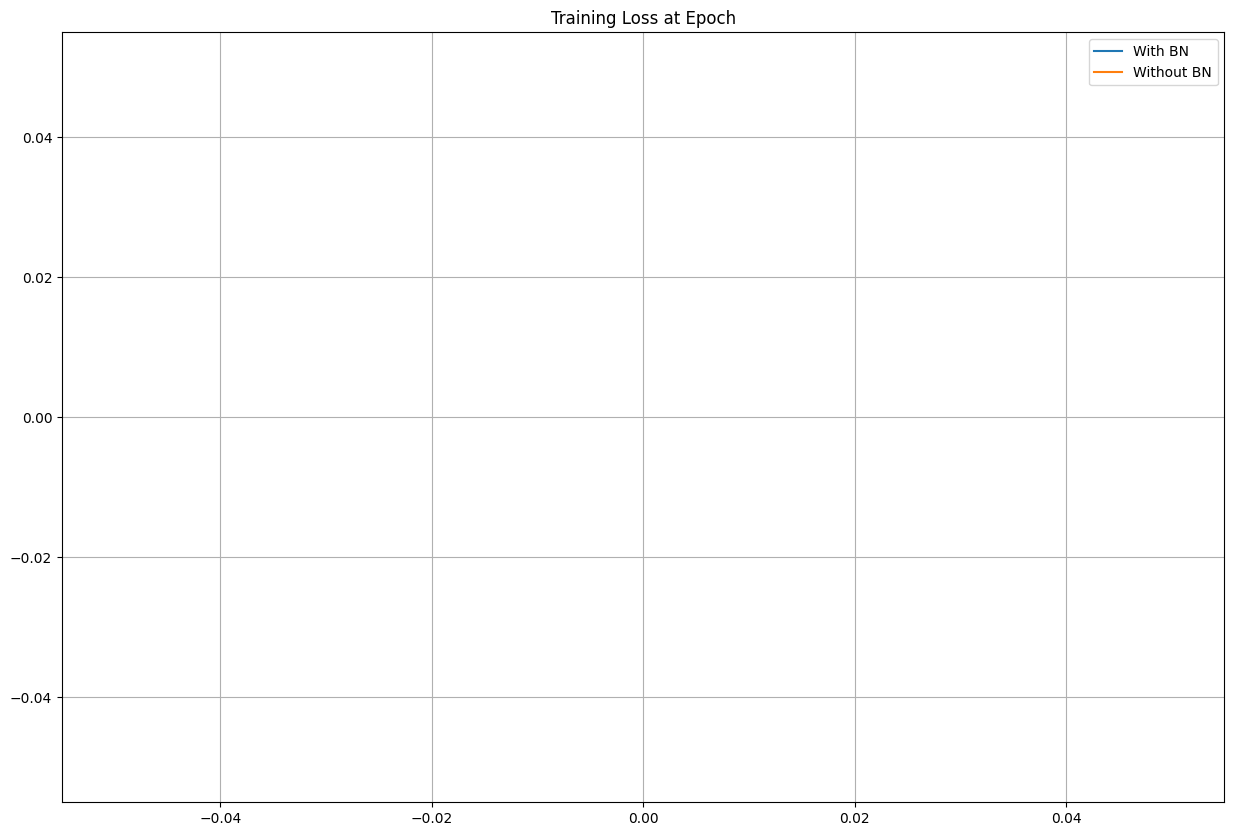

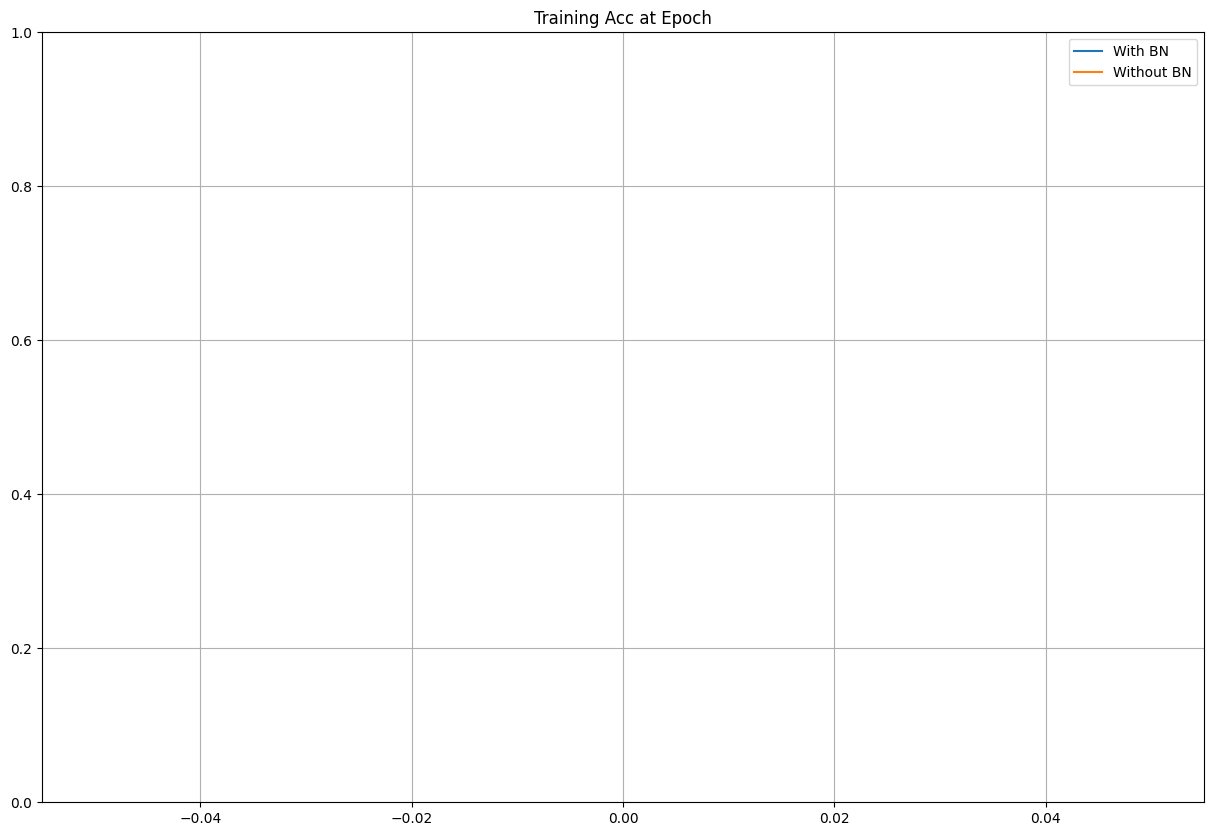

TypeError: ignored

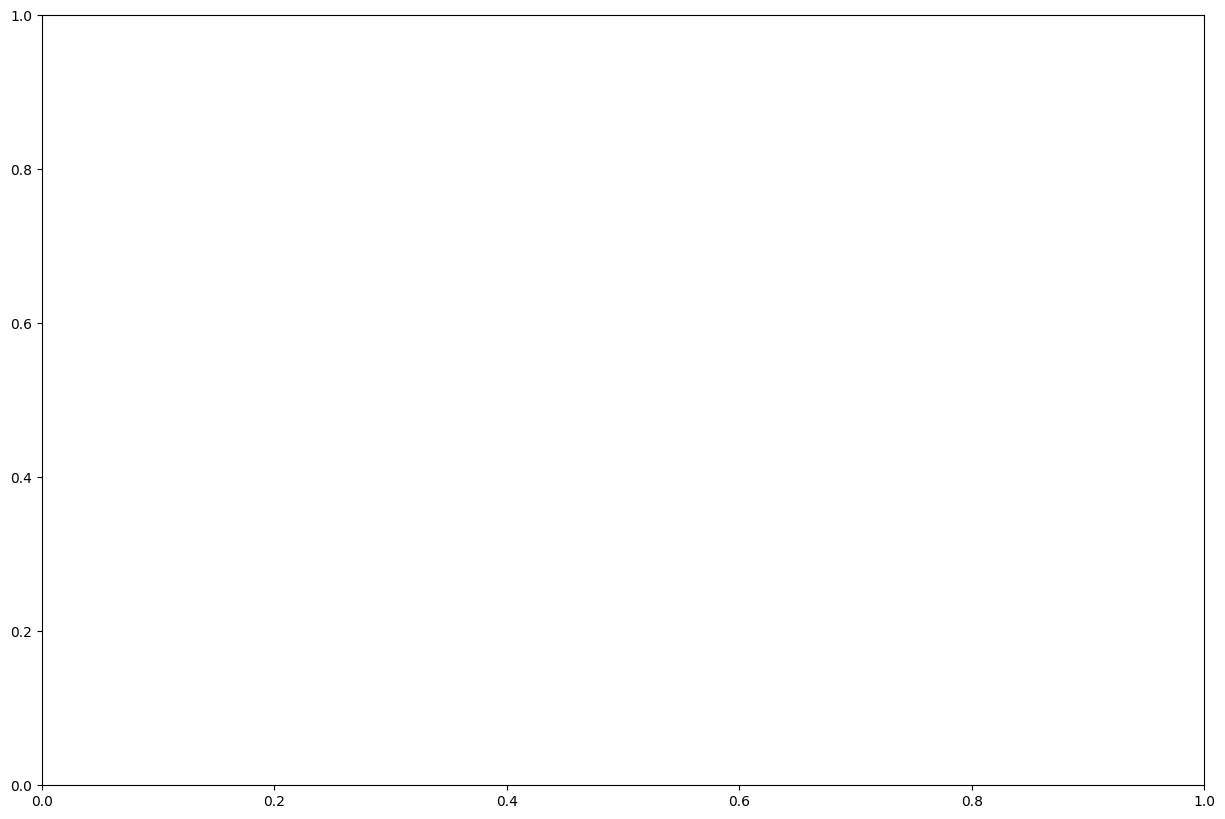

In [11]:
# bn_model 과 nn_model 의 loss 와 accuracy 비교
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')